# NLP Fundamentals in Tensorflow

> Goal of NLP is to derive information from natural language\
> Common term for NLP Problems is sequence-to-sequence problems

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Helper Functions

In [ ]:
import zipfile
def unzip_data(file) :
  """
  Unzips the file into the current working dir

  Args:
    file (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(file, "r")
  zip_ref.extractall()
  zip_ref.close()

import tensorflow as tf
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir_name = f"{dir_name}/{experiment_name}/{datetime.datetime.now().strftime('%d%m%Y-%H%M%S')}"
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir_name
  )
  print(f"Saving TensorBoard log files to: {log_dir_name}")
  return tensorboard_callback

import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Get text dataset

Dataset: Kaggle's Introduction to NLP (text samples of tweets labelled as disaster or not disaster)

Original source: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("nlp_getting_started.zip")

--2024-06-06 14:53:59--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2024-06-06 14:53:59 (31.6 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Data Exploration

Visualizing a text dataset

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_df_shuffled.text.iloc[0]

'So you have a new weapon that can cause un-imaginable destruction.'

Looks like target '1' is a disaster while '0' is not a disaster

In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


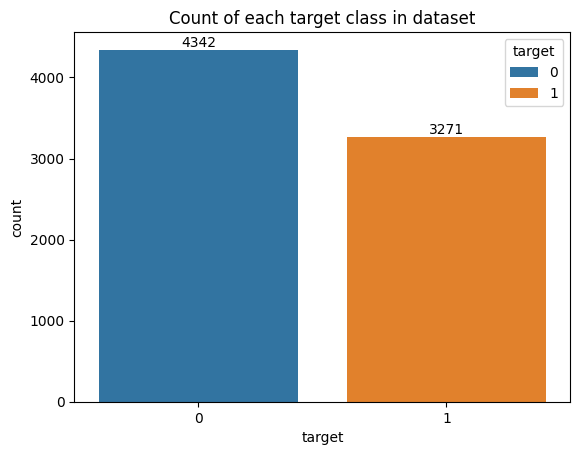

In [ ]:
import seaborn as sns
# How many examples of each class
target_count_df = pd.DataFrame(train_df.target.value_counts()).reset_index()
ax = sns.barplot(data=target_count_df, x = "target", y = "count", hue="target")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_title("Count of each target class in dataset");

In [ ]:
# Total numbers of samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Visualizing random training examples
import random
random_idx = random.randint(0, len(train_df)-6)
for row in train_df_shuffled[["text", "target"]][random_idx:random_idx+6].itertuples():
  _, text, target = row
  print(f"Target: {target}",  "(real disaster)" if target == 1 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("------\n")

Target: 1 (real disaster)
Text:
Oil and Gas Exploration Takes Seismic Shift in Gabon to Somalia - Bloomberg http://t.co/bEKrPjnYHs #??????? #Somalia

------

Target: 1 (real disaster)
Text:
I'M LAUGHING IN THE FACE OF CASUALTIES AND SORROW THE FIRST TIME I'M THINKING PAST TOMORROW BUT I AM NOT THROWIN AWAY MY SHOT

------

Target: 0 (not real disaster)
Text:
@kuualohax more like you love your husband but you're posting another man for your man crush Monday's lol

------

Target: 1 (real disaster)
Text:
@_chelsdelong12 @kendra_leigh13 I'll crash it

------

Target: 1 (real disaster)
Text:
#Laos flooding -10 villages underwater World Vision responding http://t.co/8fvQRizOUX

------

Target: 1 (real disaster)
Text:
UPDATE: 7 of the 9 Mac Pros my company bought in May have had catastrophe failures requiring repair!

------



## Creating Validation Dataset

In [ ]:
# Split training data into train and validation dataset
from sklearn.model_selection import train_test_split

# 90% train data - 10% valid data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(), train_df_shuffled["target"].to_numpy(), test_size=0.1, random_state=42)

In [ ]:
# Check train and test samples
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Visualize the first 10 training examples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [ ]:
# Visualize the first 10 validation examples
val_sentences[:10], val_labels[:10]

(array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
        'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
        'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
        "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over so

## Converting text into numbers

Converting text into numbers can be done via many ways:
* Tokenization : direct mapping of token (chararacter or word) to number
* Embedding : create a matrix of feature vector for each token

### Text Vectorization (Tokenization)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Standard TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words are in the vocabulary
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # groups of n-words
                                    output_mode="int", # how text is mapped to a token
                                    output_sequence_length=None, # how long will sequences be
                                    )

In [ ]:
# Find the average number of tokens (words) in training data
avg_tokens = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

In [ ]:
# Setup text vectorization variables
max_vocabulary_length = 10000
max_length = avg_tokens
text_vectorizer = TextVectorization(max_tokens=max_vocabulary_length, # how many words are in the vocabulary
                                    output_mode="int", # how text is mapped to a token
                                    output_sequence_length=max_length, # how long will sequences be
                                    )

In [ ]:
# Fit the text vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# Sample sentence
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Test a random sentence from training data
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence}\nVectorized text: {text_vectorizer([random_sentence])}")

Original text: https://t.co/4i0rKcbK1D
SON OF SAVIOR LAVA VIDEO
Vectorized text: [[   1 1473    6 8784  434   72    0    0    0    0    0    0    0    0
     0]]


In [ ]:
# Unique word counts in the vocabulary from training data
print(text_vectorizer.get_vocabulary()[:5]) # 5 most common words
print(text_vectorizer.get_vocabulary()[-5:]) # 5 least common words

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Embedding Tokenized Text
Using TensorFlow embedding layer,

Important parameters:
* `input_dim` = Size of vocabulary
* `output_dim`= Size of output embedding vector
* `input_length` = Length of sequences passed to the embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
embedding = Embedding(input_dim=max_vocabulary_length,
                      output_dim=128,
                      input_length=max_length)

In [ ]:
# Embed a random sentences from training data
random_sentence = random.choice(train_sentences)

random_embed = embedding(text_vectorizer([random_sentence]))
random_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03234233, -0.0402085 ,  0.04601428, ..., -0.01795088,
          0.04147366,  0.03705058],
        [-0.01470254,  0.02901978,  0.04634098, ..., -0.01056705,
         -0.03114316,  0.02091582],
        [-0.02470766,  0.03229148, -0.01538618, ...,  0.01709339,
          0.03901609,  0.04342276],
        ...,
        [ 0.02324614,  0.02200664, -0.04911403, ..., -0.04840351,
          0.02258415,  0.02574218],
        [-0.03590518, -0.04261112,  0.00235432, ..., -0.03959988,
         -0.03640318, -0.01162583],
        [ 0.00116187, -0.02497106, -0.04317429, ...,  0.03065102,
          0.00907386,  0.04130114]]], dtype=float32)>

## Modelling Experiments

Model to try for text data:
* Naive Bayes with TF-IDF encoder
* Feed-forward neural network
* LSTM (RNN)
* GRU (RNN)
* Bi-directional-LSTM (RNN)

### Evaluation Function for model experiments

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def evaluate_results(y_true, y_pred):
  """
  Output evaluation metrics (accuracy, precision, recall, and f1 score) of a binary classification model
  """

  # Calculate model accuracy
  model_acc = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall, and f1-score with weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  return {
      "accuracy": model_acc,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

### Naive Bayes with TF-IDF Encoder (Baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Tokenization and modelling Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('multinomialNB', MultinomialNB())
])

# Fit the pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('multinomialNB', MultinomialNB())])

In [ ]:
# Baseline predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
# Baseline results evaluation
baseline_res = evaluate_results(val_labels, baseline_preds)
baseline_res


{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Dense Neural Network Model

In [ ]:
# Tensorboard callback function
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Directory for saving TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Create Dense Model with Functional API
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling1D

inputs = Input(shape=(1, ), dtype=tf.string) # 1-D inputs of string
x = text_vectorizer(inputs) # turn inputs into number
x = embedding(x) # Embedding of tokenized input
x = GlobalAveragePooling1D()(x)
outputs = Dense(1, activation="sigmoid")(x) # Binary output

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")


In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
model_1.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
model_1_history = model_1.fit(x=train_sentences, y=train_labels,epochs = 5, validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240606-145410
Epoch 1/5
215/215 [==============================] - 14s 53ms/step - loss: 0.6119 - accuracy: 0.6938 - val_loss: 0.5394 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 10s 47ms/step - loss: 0.4420 - accuracy: 0.8159 - val_loss: 0.4702 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.3470 - accuracy: 0.8603 - val_loss: 0.4603 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 9s 41ms/step - loss: 0.2841 - accuracy: 0.8910 - val_loss: 0.4620 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.2376 - accuracy: 0.9104 - val_loss: 0.4769 - val_accuracy: 0.7808


In [ ]:
model_1_pred = model_1.predict(val_sentences)
model_1_pred.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [ ]:
# First 10 predictions
model_1_pred[:10]

array([[0.4003673 ],
       [0.7332223 ],
       [0.997618  ],
       [0.13486809],
       [0.12972057],
       [0.9456568 ],
       [0.9026933 ],
       [0.9939293 ],
       [0.9666498 ],
       [0.27726057]], dtype=float32)

In [ ]:
model_1_preds = tf.squeeze(tf.round(model_1_pred))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate results
model_1_res = evaluate_results(val_labels, model_1_preds)
model_1_res

{'accuracy': 0.7808398950131233,
 'precision': 0.783783808499639,
 'recall': 0.7808398950131233,
 'f1': 0.7783998521836788}

In [ ]:
# Get baseline results
baseline_res

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Seems like dense model is worse than baseline model

### RNN - Long Short Term Memory (LSTM)

RNN are useful for text data because it uses the previous output to aid the later output

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout

inputs = Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model_lstm = tf.keras.Model(inputs, outputs, name="model_lstm")

In [ ]:
model_lstm.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                        

In [ ]:
# Fit the model
model_lstm_history = model_lstm.fit(train_sentences, train_labels, epochs=8, validation_data=(val_sentences, val_labels),
                                                                                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_lstm")])

Saving TensorBoard log files to: model_logs/model_lstm/20240606-145458
Epoch 1/8
215/215 [==============================] - 15s 45ms/step - loss: 0.2308 - accuracy: 0.9212 - val_loss: 0.5699 - val_accuracy: 0.7808
Epoch 2/8
215/215 [==============================] - 8s 39ms/step - loss: 0.1627 - accuracy: 0.9422 - val_loss: 0.5906 - val_accuracy: 0.7808
Epoch 3/8
215/215 [==============================] - 9s 44ms/step - loss: 0.1368 - accuracy: 0.9488 - val_loss: 0.6850 - val_accuracy: 0.7822
Epoch 4/8
215/215 [==============================] - 8s 37ms/step - loss: 0.1058 - accuracy: 0.9585 - val_loss: 0.9283 - val_accuracy: 0.7822
Epoch 5/8
215/215 [==============================] - 9s 43ms/step - loss: 0.0807 - accuracy: 0.9699 - val_loss: 1.0990 - val_accuracy: 0.7769
Epoch 6/8
215/215 [==============================] - 9s 44ms/step - loss: 0.0700 - accuracy: 0.9692 - val_loss: 1.1451 - val_accuracy: 0.7756
Epoch 7/8
215/215 [==============================] - 8s 37ms/step - loss: 0.

In [ ]:
#  Make predictions using LSTM Model
model_lstm_preds = model_lstm.predict(val_sentences)
model_lstm_preds[:5]

24/24 [==============================] - 2s 7ms/step


array([[6.3181710e-03],
       [9.0880531e-01],
       [9.9999988e-01],
       [3.3882465e-02],
       [9.9547442e-06]], dtype=float32)

In [ ]:
# Convert model predictions into labels
model_lstm_preds = tf.squeeze(tf.round(model_lstm_preds))

In [ ]:
# Evaluate LSTM model results
model_lstm_res = evaluate_results(val_labels, model_lstm_preds)
model_lstm_res

{'accuracy': 0.7637795275590551,
 'precision': 0.7654647714490235,
 'recall': 0.7637795275590551,
 'f1': 0.7615024149378589}

### RNN - Gated Recurrent Unit (GRU)
GRU has similar features with LSTM but has less parameters

In [ ]:
# Build a RNN using GRU cell
from tensorflow.keras.layers import GRU

inputs = Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(64, return_sequences=True)(x)
x = GRU(16)(x)
x = Dense(8, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
model_gru = tf.keras.Model(inputs, outputs, name="model_gru")

In [ ]:
model_gru.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
model_gru.summary()

Model: "model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 16)                3936      
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                         

In [ ]:
# Fit the model
model_gru_history = model_gru.fit(train_sentences, train_labels, epochs=8, validation_data=(val_sentences, val_labels),
                                                                                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_gru")])

Saving TensorBoard log files to: model_logs/model_gru/20240606-145627
Epoch 1/8
215/215 [==============================] - 15s 46ms/step - loss: 0.1671 - accuracy: 0.9499 - val_loss: 0.7162 - val_accuracy: 0.7808
Epoch 2/8
215/215 [==============================] - 9s 41ms/step - loss: 0.0891 - accuracy: 0.9702 - val_loss: 0.8322 - val_accuracy: 0.7769
Epoch 3/8
215/215 [==============================] - 9s 44ms/step - loss: 0.0679 - accuracy: 0.9733 - val_loss: 0.9176 - val_accuracy: 0.7756
Epoch 4/8
215/215 [==============================] - 14s 66ms/step - loss: 0.0530 - accuracy: 0.9756 - val_loss: 0.9426 - val_accuracy: 0.7717
Epoch 5/8
215/215 [==============================] - 13s 62ms/step - loss: 0.0444 - accuracy: 0.9794 - val_loss: 1.2132 - val_accuracy: 0.7743
Epoch 6/8
215/215 [==============================] - 13s 59ms/step - loss: 0.0495 - accuracy: 0.9769 - val_loss: 1.1387 - val_accuracy: 0.7769
Epoch 7/8
215/215 [==============================] - 10s 48ms/step - loss:

In [ ]:
# Prediction using GRU RNN model
model_gru_preds = model_gru.predict(val_sentences)

# Turn prediction probabilities into target labels
model_gru_preds = tf.squeeze(tf.round(model_gru_preds))

24/24 [==============================] - 1s 6ms/step


In [ ]:
# Evaluate results
model_gru_res = evaluate_results(val_labels, model_gru_preds)
model_gru_res

{'accuracy': 0.7742782152230971,
 'precision': 0.7755035361291913,
 'recall': 0.7742782152230971,
 'f1': 0.7724787248794153}

### Bi-directional LSTM Model

In [ ]:
# Build Bi-directional LSTM Model
from tensorflow.keras.layers import LSTM, Bidirectional

inputs = Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(GRU(32))(x)
x = Dense(8, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
model_bi_dir = tf.keras.Model(inputs, outputs, name="model_bi_dir")

In [ ]:
model_bi_dir.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
model_bi_dir.summary()

Model: "model_bi_dir"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                      

In [ ]:
# Fit the model
model_bi_dir_history = model_bi_dir.fit(train_sentences, train_labels, epochs=8, validation_data=(val_sentences, val_labels),
                                                                                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_bi_dir")])

Saving TensorBoard log files to: model_logs/model_bi_dir/20240606-145856
Epoch 1/8
215/215 [==============================] - 22s 64ms/step - loss: 0.0922 - accuracy: 0.9711 - val_loss: 1.1549 - val_accuracy: 0.7690
Epoch 2/8
215/215 [==============================] - 12s 55ms/step - loss: 0.0436 - accuracy: 0.9796 - val_loss: 1.1709 - val_accuracy: 0.7717
Epoch 3/8
215/215 [==============================] - 12s 55ms/step - loss: 0.0423 - accuracy: 0.9796 - val_loss: 1.2653 - val_accuracy: 0.7638
Epoch 4/8
215/215 [==============================] - 11s 50ms/step - loss: 0.0440 - accuracy: 0.9790 - val_loss: 1.4515 - val_accuracy: 0.7677
Epoch 5/8
215/215 [==============================] - 12s 56ms/step - loss: 0.0370 - accuracy: 0.9812 - val_loss: 1.4755 - val_accuracy: 0.7651
Epoch 6/8
215/215 [==============================] - 12s 56ms/step - loss: 0.0421 - accuracy: 0.9804 - val_loss: 1.4286 - val_accuracy: 0.7533
Epoch 7/8
215/215 [==============================] - 12s 54ms/step - 

In [ ]:
# Make predictions
model_bidir_preds = model_bi_dir.predict(val_sentences)

# Turn prediction probabilities into target labels
model_bidir_preds = tf.squeeze(tf.round(model_bidir_preds))

24/24 [==============================] - 2s 9ms/step


In [ ]:
# Evaluate results
model_bidir_res = evaluate_results(val_labels, model_bidir_preds)
model_bidir_res

{'accuracy': 0.7532808398950132,
 'precision': 0.752883120923556,
 'recall': 0.7532808398950132,
 'f1': 0.7524471022550004}

In [ ]:
model_gru_res

{'accuracy': 0.7742782152230971,
 'precision': 0.7755035361291913,
 'recall': 0.7742782152230971,
 'f1': 0.7724787248794153}